# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

finally:
    os.chdir(nbPath)


%run "_dataset-selection.ipynb"

In [2]:
full_list_MCx = []
for animal, sessionList in GoodDataList[defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_MCx.append((animal,sessionList))
full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
# load the DFs
warnings.filterwarnings("ignore")
allDFs_MCx = []
for animal, session in full_list_MCx:
    path = root/animal/session
    allDFs_MCx.append(defs.prep_general(dt.load_pyal_data(path)))


warnings.filterwarnings("default")


pairFileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        pairFileList1.append((I,J))

print(f'{len(pairFileList1)=}')

len(pairFileList1)=126


# modified `get_data_array` function for __TME__

In [62]:
def get_TME_array(data_list: list[pd.DataFrame], epoch: Callable =None , area: str ='M1', model: Callable =None, n_components:int = 10) -> np.ndarray:
    """
    Applies the `model` to the `data_list` and return a data matrix of the shape: sessions x targets x trials x time x modes
    with the minimum number of trials and timepoints shared across all the datasets/targets.
    
    Parameters
    ----------
    `data_list`: list of pd.dataFrame datasets from pyalData (could also be a single dataset)
    `epoch`: an epoch function of the type `pyal.generate_epoch_fun()`
    `area`: area, either: 'M1', or 'S1', or 'PMd', ...
    `model`: a model that implements `.fit()`, `.transform()` and `n_components`. By default: `PCA(10)`. If it's an integer: `PCA(integer)`.
    `n_components`: use `model`, this is for backward compatibility
    
    Returns
    -------
    `AllData`: np.ndarray

    Signature
    -------
    AllData = get_data_array(data_list, execution_epoch, area='M1', model=10)
    all_data = np.reshape(AllData, (-1,10))
    """
    try:
        matlab.engine
        print('Matlab engine already running!')
    except NameError:
        import matlab.engine
        eng = matlab.engine.start_matlab()
        eng.cd(r'../tools/TME/', nargout=0)
        eng.addpath(eng.pwd()+'/util', eng.pwd()+'/genTME')

    if isinstance(data_list, pd.DataFrame):
        data_list = [data_list]
    if model is None:
        model = PCA(n_components=n_components, svd_solver='full')
    elif isinstance(model, int):
        model = PCA(n_components=model, svd_solver='full')
    
    field = f'{area}_rates'
    n_shared_trial = np.inf
    target_ids = np.unique(data_list[0].target_id)
    for df in data_list:
        for target in target_ids:
            df_ = pyal.select_trials(df, df.target_id== target)
            n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    # finding the number of timepoints
    if epoch is not None:
        df_ = pyal.restrict_to_interval(data_list[0],epoch_fun=epoch)
    n_timepoints = int(df_[field][0].shape[0])

    # pre-allocating the data matrix
    AllData = np.empty((len(data_list), len(target_ids), n_shared_trial, n_timepoints, model.n_components))
    AllRates = []
    rng = np.random.default_rng(12345)
    for session, df in enumerate(data_list):
        df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
        rates = []
        for targetIdx,target in enumerate(target_ids):
            df__ = pyal.select_trials(df_, df_.target_id==target)
            all_id = df__.trial_id.to_numpy()
            # select the right number of trials to each target
            df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
            rates.append(np.concatenate(df__[field].values, axis=0))
        
        rates = np.stack(rates, axis=2)  # rates: time x neuron x target
        # Use the surrogate data generated with TME
        rates = eng.computeTME(rates,'surrogate-TNC')
        rates = np.array(rates)
        AllRates.append(rates)
        rates_ = np.reshape(rates, (-1,rates.shape[1]))
        rates_model = model.fit(rates_)
        df_ = pyal.apply_dim_reduce_model(df_, rates_model, field, '_pca');
        for targetIdx,target in enumerate(target_ids):
            df__ = pyal.select_trials(df_, df_.target_id==target)
            all_id = df__.trial_id.to_numpy()
            # to guarantee shuffled ids
            while ((all_id_sh := rng.permutation(all_id)) == all_id).all():
                continue
            all_id = all_id_sh
            # select the right number of trials to each target
            df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
            for trial, trial_rates in enumerate(df__._pca):
                AllData[session,targetIdx,trial, :, :] = trial_rates

    return AllData, AllRates


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

min_trials=15
min_time=15


Text(0.5, 0, 'sessions')

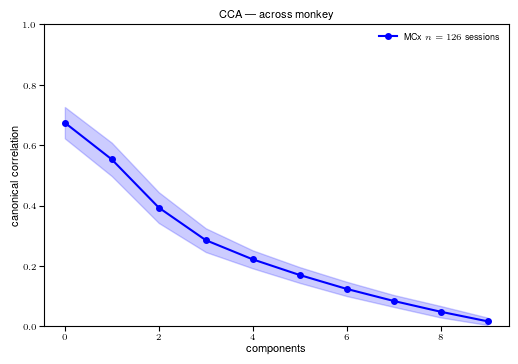

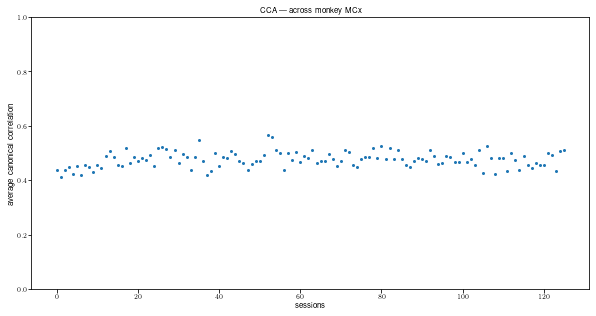

In [63]:
side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
side2df = [allDFs_MCx[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1, SurrData1 = get_TME_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
AllData2, SurrData2 = get_TME_array(side2df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

warnings.filterwarnings("default")

allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allCCs0.append(dt.canoncorr(data1, data2))
allCCs0 = np.array(allCCs0).T

# plot
_,ax = plt.subplots(dpi=100)
utility.shaded_errorbar(ax, allCCs0, color='b', marker = 'o', label=f'{defs.areas[2]} $n={allCCs0.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('components')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- across monkey', usetex=True);

_,ax = plt.subplots(ncols=1, figsize=(10,5))
ax.plot(allCCs0[:4,:].mean(axis=0),'.')
ax.set_ylabel('average canonical correlation')
ax.set_title(f'CCA --- across monkey {defs.areas[2]} ', usetex=True);
ax.set_ylim([0,1])
ax.set_xlabel('sessions')


#### Comparing the `cov` matrix of the real and surrogate data

In [92]:
def get_neural_and_TME_data(data_list: pd.DataFrame, epoch: Callable =None , area: str ='M1') -> np.ndarray:
    """
    similar to `get_data_array` to get the neural data of a singgle session
    """
    assert isinstance(data_list, pd.DataFrame)
    
    field = f'{area}_rates'
    n_shared_trial = np.inf
    target_ids = np.unique(data_list.target_id)
    for target in target_ids:
        df_ = pyal.select_trials(data_list, data_list.target_id== target)
        n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    # finding the number of timepoints
    if epoch is not None:
        df_ = pyal.restrict_to_interval(data_list,epoch_fun=epoch)
    n_timepoints = int(df_[field][0].shape[0])

    # pre-allocating the data matrix
    AllData = np.empty((len(target_ids), n_shared_trial, n_timepoints, data_list[field][0].shape[1]))

    rng = np.random.default_rng(12345)
    df_ = pyal.restrict_to_interval(data_list, epoch_fun=epoch) if epoch is not None else df

    for targetIdx,target in enumerate(target_ids):
        df__ = pyal.select_trials(df_, df_.target_id==target)
        all_id = df__.trial_id.to_numpy()
        # to guarantee shuffled ids
        while ((all_id_sh := rng.permutation(all_id)) == all_id).all():
            continue
        all_id = all_id_sh
        # select the right number of trials to each target
        df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
        for trial, trial_rates in enumerate(df__[field]):
            AllData[targetIdx,trial, :, :] = trial_rates

    try:
        matlab.engine
        print('Matlab engine already running!')
    except NameError:
        import matlab.engine
        eng = matlab.engine.start_matlab()
        eng.cd(r'../tools/TME/', nargout=0)
        eng.addpath(eng.pwd()+'/util', eng.pwd()+'/genTME')

    rates = np.transpose(AllData.reshape(AllData.shape[0], -1, AllData.shape[-1]),(1, 2, 0))  # time x neuron x target
    rates = np.require(rates, dtype=np.float32, requirements=['A', 'O', 'W', 'C'])
    # Use the surrogate data generated with TME
    TME_rates = eng.computeTME(rates,'surrogate-TNC')
    TME_rates = np.array(TME_rates)

    return AllData, TME_rates


In [95]:
real_rates, surr_rates = get_neural_and_TME_data (side1df[0], defs.exec_epoch, area=defs.areas[2])
real_rates = np.transpose(real_rates.reshape(real_rates.shape[0], -1, real_rates.shape[-1]),(1, 2, 0))
real_rates = np.require(real_rates, dtype=np.float32, requirements=['A', 'O', 'W', 'C'])

target covariance

Text(0.5, 0.85, 'Target covariance matrices')

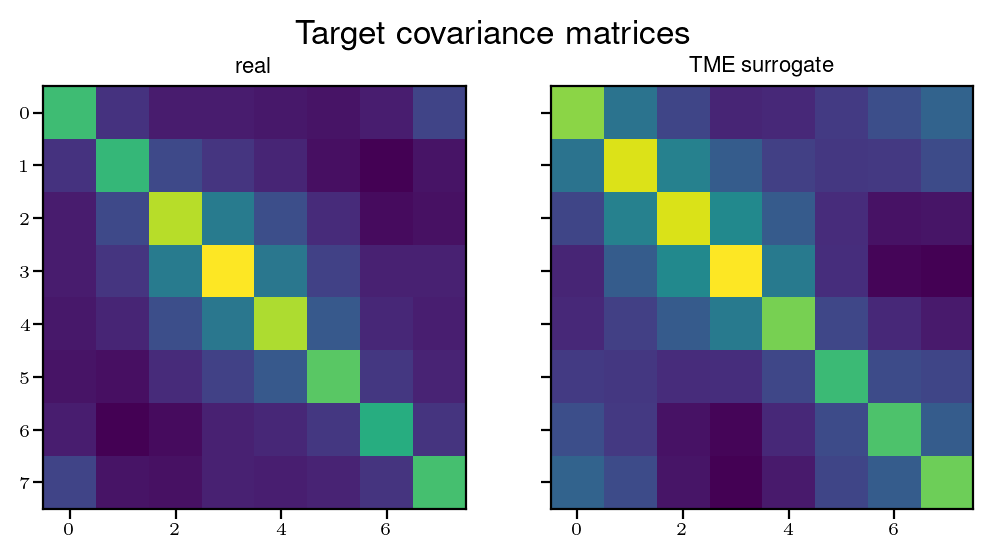

In [111]:
# reshape the data
surr_cov = np.cov(surr_rates.reshape(-1, surr_rates.shape[-1]), rowvar=False)
real_cov = np.cov(real_rates.reshape(-1, real_rates.shape[-1]), rowvar=False)


fig, axes = plt.subplots(1,2, sharex=True, sharey=True, squeeze=True, dpi=200)
axes[0].imshow(real_cov)
axes[0].set_title('real')
axes[1].imshow(surr_cov)
axes[1].set_title('TME surrogate')
fig.suptitle('Target covariance matrices', y=.85)